In [2]:
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

In [3]:
COUNTS_PATH = "../../process_geuvadis_data/log_tpm/corrected_log_tpm.annot.csv.gz"
GENE_CLASS_PATH = "../../finetuning/data/h5_bins_384_chrom_split/gene_class.csv"

CONTEXT_SIZES=[
    10000, 20000, 30000, 40000, 49152, 75000, 100000, 200000, 
    300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000
]

MODEL_TO_FNAME = {
    "TOP1": "top1.csv",
    "LASSO": "lasso.csv",
    "ElasticNet": "enet.csv",
    "BLUP": "blup.csv",
}

In [4]:
counts_df = pd.read_csv(COUNTS_PATH, index_col="our_gene_name")

class_df = pd.read_csv(GENE_CLASS_PATH, index_col=0)
random_split_genes = class_df[class_df["class"] == "random_split"].index.tolist()
population_split_genes = class_df[class_df["class"] == "yri_split"].index.tolist()
class_to_genes = {"random_split": random_split_genes, "population_split": population_split_genes}

In [5]:
def compute_mean_pearson(
    counts_df: pd.DataFrame,
    preds_path: str,
    genes: list[str],
):
    corrs = []
    preds_df = pd.read_csv(preds_path, index_col=0)
    for gene in genes:
        preds = preds_df.loc[gene].dropna()
        counts = counts_df.loc[gene, preds.index]
        assert len(preds) == len(counts) == 77
        corr, _ = pearsonr(preds.values.astype(float), counts.astype(float))
        corr = np.nan_to_num(corr)
        corrs.append(corr)
    return np.mean(corrs)

In [6]:
results = defaultdict(list)
for model, fname in MODEL_TO_FNAME.items():
    for context_size in CONTEXT_SIZES:
        preds_path = os.path.join("preds", str(context_size), fname)
        assert os.path.exists(preds_path)
        
        for gene_class, genes in class_to_genes.items():
            mean_pearson = compute_mean_pearson(counts_df, preds_path, genes)
            results["model"].append(model)
            results["context_size"].append(context_size)
            results["gene_class"].append(gene_class)
            results["mean_pearson"].append(mean_pearson)

results_df = pd.DataFrame(results)

/tmp/ipykernel_1265731/3433533702.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds.values.astype(float), counts.astype(float))
/tmp/ipykernel_1265731/3433533702.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds.values.astype(float), counts.astype(float))
/tmp/ipykernel_1265731/3433533702.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds.values.astype(float), counts.astype(float))
/tmp/ipykernel_1265731/3433533702.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds.values.astype(float), counts.astype(float))
/tmp/ipykernel_1265731/3433533702.py:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(preds.values.astype(

In [7]:
results_df["model"] = results_df["model"].map({
    "TOP1": "Top SNP",
    "LASSO": "LASSO",
    "ElasticNet": "Elastic net/PrediXcan",
    "BLUP": "BLUP",
})

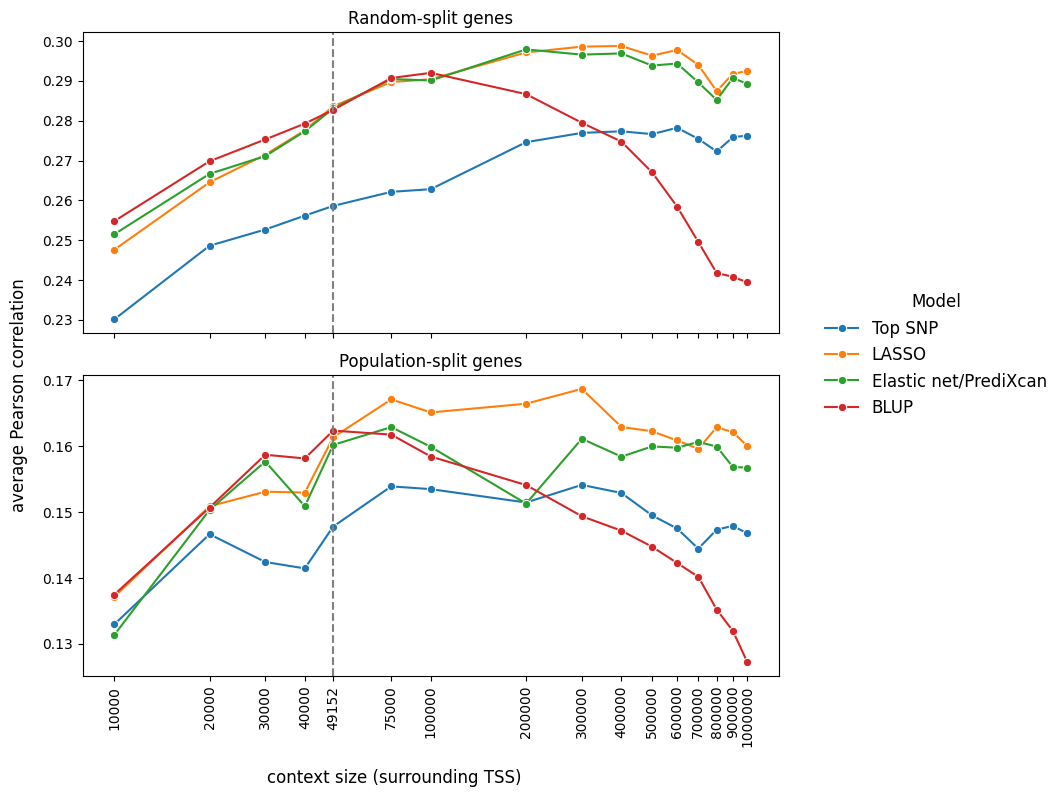

In [8]:
fig, axs = plt.subplots(nrows=2, figsize=(8, 8), sharex=True)

sns.lineplot(
    data=results_df[results_df["gene_class"] == "random_split"],
    x="context_size",
    y="mean_pearson",
    hue="model",
    marker="o",
    ax=axs[0],
)
axs[0].set_xscale("log")
axs[0].minorticks_off()
axs[0].set_xticks(CONTEXT_SIZES, labels=CONTEXT_SIZES, rotation=90)
axs[0].set(xlabel="", ylabel="", title="Random-split genes")
axs[0].axvline(x=49152, color="gray", linestyle="--")
axs[0].legend().remove()


sns.lineplot(
    data=results_df[results_df["gene_class"] == "population_split"],
    x="context_size",
    y="mean_pearson",
    hue="model",
    marker="o",
    ax=axs[1]
)
axs[1].set_xscale("log")
axs[1].minorticks_off()
axs[1].set_xticks(CONTEXT_SIZES, labels=CONTEXT_SIZES, rotation=90)
axs[1].set(xlabel="", ylabel="", title="Population-split genes")
axs[1].axvline(x=49152, color="gray", linestyle="--")
axs[1].legend().remove()

# Place the legend outside the plot
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles, labels, loc="center left", bbox_to_anchor=(1.02, 0.55), ncol=1,
    title="Model", fontsize=12, title_fontsize=12, frameon=False
)

fig.supxlabel("context size (surrounding TSS)")
fig.supylabel("average Pearson correlation")
plt.tight_layout()
plt.savefig("/data/yosef3/users/ruchir/finetuning-enformer/analysis/figures/linear_perf_by_context_size.pdf", bbox_inches="tight")
plt.show()

In [10]:
# For each model and both gene classes, compute the percentage gap between performance at 49,152 and the
# best performance at any context size
for gene_class in results_df["gene_class"].unique():
    for model in results_df["model"].unique():
        subset_df = results_df[(results_df["gene_class"] == gene_class) & (results_df["model"] == model)]
        perf_by_context_size = subset_df.set_index("context_size")["mean_pearson"].to_dict()
        our_context_size_perf = perf_by_context_size[49152]
        best_perf = max([v for v in perf_by_context_size.values()])
        gap = (best_perf - our_context_size_perf) / best_perf
        print(f"{gene_class} {model}: {gap:.2%} gap between 49,152 and best context size")

random_split Top SNP: 7.05% gap between 49,152 and best context size
random_split LASSO: 5.07% gap between 49,152 and best context size
random_split Elastic net/PrediXcan: 4.98% gap between 49,152 and best context size
random_split BLUP: 3.18% gap between 49,152 and best context size
population_split Top SNP: 4.10% gap between 49,152 and best context size
population_split LASSO: 4.35% gap between 49,152 and best context size
population_split Elastic net/PrediXcan: 1.66% gap between 49,152 and best context size
population_split BLUP: 0.00% gap between 49,152 and best context size


In [9]:
results_df

,model,context_size,gene_class,mean_pearson
0,Top SNP,10000,random_split,0.230149
1,Top SNP,10000,population_split,0.132971
2,Top SNP,20000,random_split,0.248623
3,Top SNP,20000,population_split,0.146659
4,Top SNP,30000,random_split,0.252697
...,...,...,...,...
123,BLUP,800000,population_split,0.135224
124,BLUP,900000,random_split,0.240841
125,BLUP,900000,population_split,0.131980
126,BLUP,1000000,random_split,0.239433
